In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import quandl
import cvxportfolio as cp

In [63]:
# Get problem data
tickers = ['AMZN', 'GOOGL', 'MCD', 'NKE']
start_date='2012-01-01'
end_date='2016-12-31'
returns = pd.DataFrame(dict([(ticker, quandl.get('WIKI/'+ticker, 
                                    start_date=start_date, 
                                    end_date=end_date)['Adj. Close'].pct_change())
                for ticker in tickers]))
returns[["USDOLLAR"]]=quandl.get('FRED/DTB3', start_date=start_date, end_date=end_date)/250
returns = returns.fillna(method='ffill').iloc[1:]

In [64]:
spread=pd.DataFrame(index=returns.index, columns=returns.columns[:-1], data=10E-4) ##TODO
tcost_model=cp.TcostModel(spread=10E-4, nonlin_term=False) ## nonlin term should be inferred
borrow_costs=pd.DataFrame(index=returns.index, columns=returns.columns[:-1], data=1E-4) ##TODO
hcost_model=cp.HcostModel(borrow_costs=borrow_costs)

#estimates
r_hat = returns.rolling(center=False, window=250, min_periods=250).mean().shift(1).dropna()
Sigma_hat = returns.rolling(center=False, window=250, min_periods=250).cov().shift(1,0,0).dropna()

AttributeError: 'float' object has no attribute 'columns'

In [65]:
# tcost_model=cp.TcostModel(spread=10E-4) #half_spread
# hcost_model=cp.HcostModel(borrow_costs=1E-4)

# # make sure gammas are >= 0 
# # tcost, hcost, alpha should be able to take a pd Series with index=tickers, values=values
# # every thing passed to *costmodel should be able to be scalar series or DF

# alpha source should be return forecast

# sector constraint should be equality

# SPO should have 
# SPO(objective, constraints)
# so that rebalance could also be there...

# cost -> constraint should be done

# cost object should be used as constraints too. like costs=[gamma_leverage*Leverage()]
# and constraints=[Leverage()<= 3]

# documentation should be like cvxpy. we have variables constants parameters etc. we have a library of functions 
# that manipulate basic objects, each one is documented...
# we have standard operators +-*/ etc.


In [61]:
# do this thresholding, at 4 basis points

r_hat[r_hat>4E-4]=4E-4
r_hat[r_hat<-4E-4]=-4E-4

In [34]:
#### Set up optimization
alpha_source = cp.AlphaSource(r_hat)
risk = cp.FullSigma(Sigma_hat)
gamma_risk = 5.
gamma_trade = 1.
gamma_hold = 1.
leverage_limit = cp.LeverageLimit(3)
spo_policy = cp.SinglePeriodOpt(alpha_source, [gamma_risk*risk,
                                            gamma_trade*tcost_model,
                                            gamma_hold*hcost_model],
                                            [leverage_limit])

#### Run backtest
market_sim=cp.MarketSimulator(returns, [tcost_model, hcost_model], cash_key='USDOLLAR') 
init_portfolio = pd.Series(index=returns.columns, data=0.)
init_portfolio.USDOLLAR = 100
result=market_sim.run_backtest(init_portfolio,
                                 start_time='2013-01-03', 
                                 end_time='2016-12-31',  
                                 policy=spo_policy)

In [35]:
result.summary()
# add num periods
# start time
# end time

Portfolio return: 16.83%
Excess return: 5.26%
Excess risk: 14.73%
Sharpe ratio: 0.36
Max. drawdown: 19.56%
Turnover: 87.49%


(80, 300)

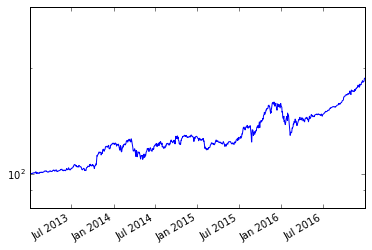

In [55]:
result.v.plot(logy=True)
plt.ylim([80
    ,300])

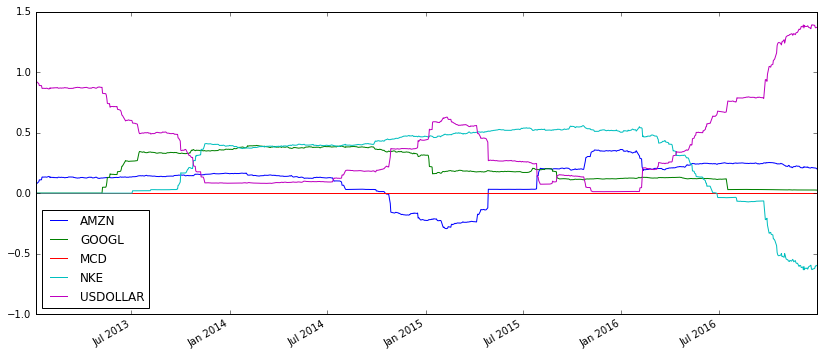

In [36]:
result.w.plot(figsize=(14,6))

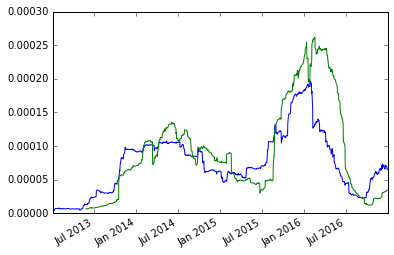

In [45]:
result.policy_FullSigma.plot()
(result.returns**2).rolling(window=100).mean().plot()

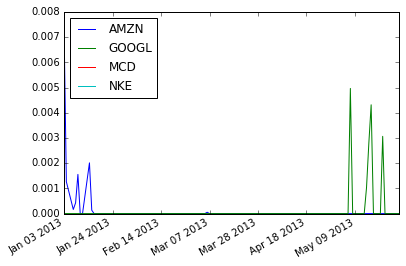

In [46]:
result.simulator_TcostModel.head(100).plot()

In [37]:
# from IPython.display import display

# summary=pd.DataFrame(index=[])

# summary.loc[0,r'$\bar R^\text{e}$'] = '%.2f%%'%(self.excess_returns.mean()*100*self.PPY)
# summary.loc[0,r'$\sigma^\text{e}$'] = '%.2f%%'%(self.excess_returns.std()*100*np.sqrt(self.PPY))
# summary.loc[0,r'$\bar R^\text{p}$'] = '%.2f%%'%(self.returns.mean()*100*self.PPY)
# summary.loc[0,r'SR'] = '%.2f'%self.sharpe_ratio
# summary.loc[0,r'MDD'] = '%.2f%%'%self.max_drawdown
# summary.loc[0,r'Turnover']= '%.2f%%'%(self.turnover.mean()*100*self.PPY)


# display(summary)